### application
* <이미지, 비디오, 음악, 자연어> 생성
* 이미지to이미지 변환, 이미지 초고해상도, 신약개발, 비디오 다음프레임 예측

### architecture
* 생성기 : 사전분포로부터 랜덤노이즈를 샘플링하여 생성기에 전달 -> 그로부터 데이터 생성
* 판별기 : 생성기의 생성데이터(0)와 원본 데이터셋의 데이터(1)를 동시에 입력받아 지도학습 수행

In [1]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout
from tensorflow.keras.layers import BatchNormalization, Activation, ZeroPadding2D
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import UpSampling2D, Conv2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import initializers


import matplotlib.pyplot as plt

import sys

import numpy as np
import tqdm

# Vanilla GAN

In [2]:
# Set the seed for reproducible result
np.random.seed(1000)

# random noise dimension
randomDim = 10 

# Load MNIST data
(X_train, _), (_, _) = mnist.load_data()
X_train = (X_train.astype(np.float32) - 127.5)/127.5     # scaling -1 ~ 1
print(X_train.shape)
X_train = X_train.reshape(60000, 784)
print(X_train.shape)

11493376/11490434 [==============================] - 0s 0us/step
(60000, 28, 28)
(60000, 784)


In [7]:
# network define
generator = Sequential()
generator.add(Dense(256, input_dim = randomDim))         # random noise input
generator.add(LeakyReLU(0.2))
generator.add(Dense(512))
generator.add(LeakyReLU(0.2))
generator.add(Dense(1024))
generator.add(LeakyReLU(0.2))
generator.add(Dense(784, activation = "tanh"))           # generator의 output은 원본데이터와 shape가 동일해야함

discriminator = Sequential()
discriminator.add(Dense(1024, input_dim = 784))          
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))
discriminator.add(Dense(512))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))
discriminator.add(Dense(256))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3)) 
discriminator.add(Dense(1, activation = "sigmoid"))       # true, false
discriminator.compile(loss = "binary_crossentropy", optimizer = "adam")

In [8]:
# e2e gan
discriminator.trainable = False                           
ganInput = Input(shape = (randomDim, ))
x = generator(ganInput)
ganOutput = discriminator(x)
gan = Model(inputs = ganInput, outputs = ganOutput)
gan.compile(loss = "binary_crossentropy", optimizer = "adam")

dLosses = []
gLosses = []

In [12]:
## helper functions

# Plot the loss from each batch
def plotLoss(epoch):
    plt.figure(figsize=(10, 8))
    plt.plot(dLosses, label='Discriminitive loss')
    plt.plot(gLosses, label='Generative loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    # plt.savefig('images/gan_loss_epoch_%d.png' % epoch)

# Create a wall of generated MNIST images
def saveGeneratedImages(epoch, examples=100, dim=(10, 10), figsize=(10, 10)):
    noise = np.random.normal(0, 1, size=[examples, randomDim])
    generatedImages = generator.predict(noise)
    generatedImages = generatedImages.reshape(examples, 28, 28)

    plt.figure(figsize=figsize)
    for i in range(generatedImages.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generatedImages[i], interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('images/gan_generated_image_epoch_%d.png' % epoch)

In [17]:
def train(epochs = 1, batchSize = 128):
    batchCount = int(X_train.shape[0] / batchSize)
    print('Epochs : ',epochs)
    print ('Batch size:', batchSize)
    print ('Batches per epoch:', batchCount)

    for e in range(1, epochs + 1):
        print('-'*15, 'Epoch %d' % e, '-'*15)
        for _ in range(batchCount):
            # 랜덤 노이즈와 이미지를 취함
            noise = np.random.normal(0, 1, size = [batchSize, randomDim])
            imageBatch = X_train[np.random.randint(0, X_train.shape[0], size = batchSize)]

            # 가짜 MNIST 이미지 생성 후 진짜 이미지와 연결
            generatedImages = generator.predict(noise)
            X = np.concatenate([imageBatch, generatedImages])

            # 생성/실제 이미지의 레이블
            yDis = np.zeros(2*batchSize)
            # One-sided label smoothing - 실제 이미지만 1에 가깝게 레이블링 (가짜는 0으로 되어있음)
            yDis[:batchSize] = 0.9

            # 판별기 훈련
            discriminator.trainable = True
            dloss = discriminator.train_on_batch(X, yDis)

            # 생성기 훈련
            noise = np.random.normal(0, 1, size = [batchSize, randomDim])
            yGen = np.ones(batchSize)
            discriminator.trainable = False # 이때 판별자의 파라미터는 변경되지 않도록함
            gloss = gan.train_on_batch(noise, yGen)
        
        # 각 에폭의 가장 마지막 배치에서의 손실을 저장
        dLosses.append(dloss)
        gLosses.append(gloss)

        # if e == 1 or e % 20 == 0:
        #     saveGeneratedImages(e)
        
    plotLoss(e)

Epochs :  120
Batch size: 128
Batches per epoch: 468
--------------- Epoch 1 ---------------
--------------- Epoch 2 ---------------
--------------- Epoch 3 ---------------
--------------- Epoch 4 ---------------
--------------- Epoch 5 ---------------
--------------- Epoch 6 ---------------
--------------- Epoch 7 ---------------
--------------- Epoch 8 ---------------
--------------- Epoch 9 ---------------
--------------- Epoch 10 ---------------
--------------- Epoch 11 ---------------
--------------- Epoch 12 ---------------
--------------- Epoch 13 ---------------
--------------- Epoch 14 ---------------
--------------- Epoch 15 ---------------
--------------- Epoch 16 ---------------
--------------- Epoch 17 ---------------
--------------- Epoch 18 ---------------
--------------- Epoch 19 ---------------
--------------- Epoch 20 ---------------
--------------- Epoch 21 ---------------
--------------- Epoch 22 ---------------
--------------- Epoch 23 ---------------
-------------

FileNotFoundError: ignored

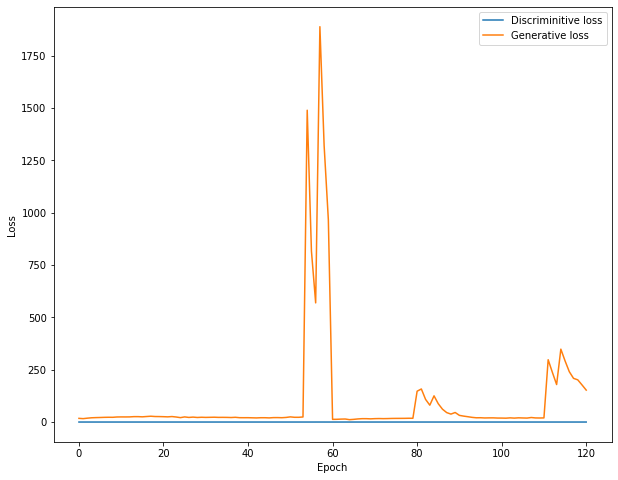

In [18]:
train(120, 128)